In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt

In [3]:
basename = "/mnt/c/Users/guido/data/olympic-ranking-170dd62c8ed8b308d7107a0cd69db75f/result-"

In [11]:
@numba.njit
def bond_counts_from_vector(vector):
    counts = np.zeros((3,3))
    bonds = np.array(((8, 27), (19, 20), (18, 19), (6, 19), (20, 21), (20, 34), (21, 35), (2, 21), (0, 22), (1, 23), (4, 24), (5, 25), (7, 26), (9, 18), (17, 18), (11, 28), (12, 29), (13, 30), (14, 31), (16, 32), (17, 33), (8, 9), (9, 10), (1, 2), (0, 1), (2, 3), (3, 4), (3, 6), (4, 5), (0, 5), (6, 7), (7, 8), (10, 11), (10, 15), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17)))
    for row in range(len(bonds)):
        a, b = bonds[row]
        if a > 21 or b > 21:
            continue
        counts[vector[a], vector[b]] += 1
    ret = (counts + counts.T)
    return np.hstack((ret[0,:], ret[1,1:], ret[2,2:]))
@numba.njit
def inner_counts(vector):
    counts = np.zeros(3)
    idx = np.array((2, 3, 6, 19, 9, 18, 10, 15))
    for value in vector[idx]:
        counts[value] += 1
    return counts[1:]
@numba.njit
def ring(vector, ringidx):
    idx = np.array([[0, 1, 2, 3, 4, 5],
    [21, 20, 19, 6, 2, 3],
    [6, 19, 18, 9, 8, 7],
    [17, 16, 15, 10, 9, 18],
    [10, 15, 14, 13, 12, 11]])[ringidx]
    counts = np.zeros(3)
    for value in vector[idx]:
        counts[value] += 1
    return counts[1:]

In [7]:
def describe(vector):
    return np.hstack((bond_counts_from_vector(vector), inner_counts(vector), ring(vector, 0), ring(vector, 1), ring(vector, 2), ring(vector, 3), ring(vector, 4)))
%timeit describe(mollist[0])

26.4 µs ± 8.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


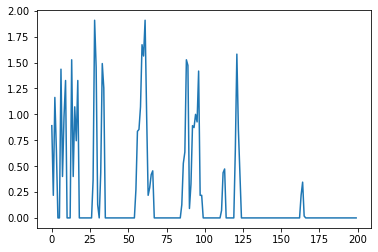

In [10]:
plt.plot(results[:, 5] / counts)

In [22]:
def describe_file(segment):
    mollist = np.fromfile(basename + segment, dtype=np.int8).reshape(-1, 22)
    ranking = np.fromfile(f"{basename}{segment}.ranked", dtype=np.int32)
    parts = np.array_split(ranking, 200)
    results = np.zeros((len(parts), 18))
    counts = []
    for pidx, part in enumerate(parts):
        counts.append(len(part))
        for mol in part:
            results[pidx] += describe(mollist[mol])
    counts = np.array(counts)
    
    np.savetxt(f'{basename}{segment}.counts', counts)
    np.savetxt(f'{basename}{segment}.description', results)
#describe_file("18")

In [28]:
bonds = np.array(((8, 27), (19, 20), (18, 19), (6, 19), (20, 21), (20, 34), (21, 35), (2, 21), (0, 22), (1, 23), (4, 24), (5, 25), (7, 26), (9, 18), (17, 18), (11, 28), (12, 29), (13, 30), (14, 31), (16, 32), (17, 33), (8, 9), (9, 10), (1, 2), (0, 1), (2, 3), (3, 4), (3, 6), (4, 5), (0, 5), (6, 7), (7, 8), (10, 11), (10, 15), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17)))
neighbors = []
for i in range(22):
    neighbors.append([_[1] for _ in bonds if _[0] == i and _[1] < 22] + [_[0] for _ in bonds if _[1] == i and _[0] < 22])

In [4]:
mollist = np.fromfile(basename + "03", dtype=np.int8).reshape(-1, 22)

In [52]:
def describe_neighbors(mol):
    results = np.zeros(6)
    for pos in np.where(mol != 0)[0]:
        ns = mol[neighbors[pos]]
        results[(mol[pos]-1)*3:mol[pos]*3] = np.bincount(ns, minlength=3)
    return results[[1,2,5]] #NN, BN, BB  # NC NN NB BC BN BB

In [60]:
def describe_file_neighbors(segment):
    mollist = np.fromfile(basename + segment, dtype=np.int8).reshape(-1, 22)
    ranking = np.fromfile(f"{basename}{segment}.ranked", dtype=np.int32)
    parts = np.array_split(ranking, 200)
    results = np.zeros((len(parts), 3))
    for pidx, part in enumerate(parts):
        for mol in part:
            results[pidx] += describe_neighbors(mollist[mol])
    
    return results
    np.savetxt(f'{basename}{segment}.description_neighbors', results)
q = describe_file_neighbors("09")

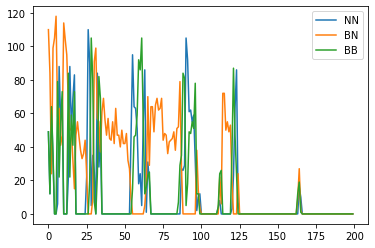

In [59]:
plt.plot(q[:, 0], label='NN')
plt.plot(q[:, 1], label='BN')
plt.plot(q[:, 2], label='BB')
plt.legend()

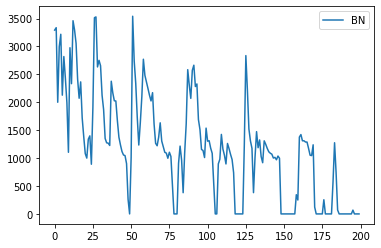

In [62]:
#plt.plot(q[:, 0], label='NN')
plt.plot(q[:, 1], label='BN')
#plt.plot(q[:, 2], label='BB')
plt.legend()

In [6]:
len(mollist[0])

22

In [14]:
def distance_matrix(fn):
    lines = open(fn).readlines()
    lines = lines[2:2+22]
    lines = [[float(__) for __ in _.strip().split()[1:]] for _ in lines]
    return np.array(lines)
pos = distance_matrix("/mnt/c/Users/guido/data/olympic-ranking-170dd62c8ed8b308d7107a0cd69db75f/inp.xyz")

In [17]:
from scipy.spatial.distance import pdist,squareform

In [21]:
dm = squareform(pdist(pos))**2

In [25]:
molspec = mollist[0]

In [73]:
@numba.njit
def truncated_rmsd(dm, selector):
    subset = dm[selector, selector].flatten()
    subset = subset[subset > 1e-2]
    if len(subset) > 0:
        return subset.mean()
    return 0
@numba.njit
def describe_rmsd(molspec):
    ns = np.where(molspec == 1)[0]
    bs = np.where(molspec == 2)[0]
    
    rmsd_bn = 0
    count_bn = 0
    for n in ns:
        for b in bs:
            rmsd_bn += dm[n, b]
            count_bn += 1
    rmsd_bn /= count_bn
    
    rmsd_bb = 0
    count_bb = 0
    for b1 in bs:
        for b2 in bs:
            if b1 == b2:
                continue
            rmsd_bb += dm[b1, b2]
            count_bb += 1
    if count_bb > 0:
        rmsd_bb /= count_bb
    
    rmsd_nn = 0
    count_nn = 0
    for n1 in ns:
        for n2 in ns:
            if n1 == n2:
                continue
            rmsd_nn += dm[n1, n2]
            count_nn += 1
    if count_nn > 0:
        rmsd_nn /= count_nn
    
    #rmsd_bn = dm[ns,bs].mean()
    #rmsd_bb = truncated_rmsd(dm, bs)
    #rmsd_nn = truncated_rmsd(dm, ns)
    return np.array((rmsd_bb, rmsd_bn, rmsd_nn))

In [89]:
def describe_file_neighbors(segment):
    mollist = np.fromfile(basename + segment, dtype=np.int8).reshape(-1, 22)
    ranking = np.fromfile(f"{basename}{segment}.ranked", dtype=np.int32)
    parts = np.array_split(ranking, 200)
    results = np.zeros((len(parts), 3))
    scaling = np.zeros((len(parts), 3))
    for pidx, part in enumerate(parts):
        for mol in part:
            described = describe_rmsd(mollist[mol])
            scaling[pidx] += described > 0
            results[pidx] += described
    
    scaling[scaling == 0] = 1
    results = results/scaling
    np.savetxt(f'{basename}{segment}.rmsd', results)
    return results
q = describe_file_neighbors("33")

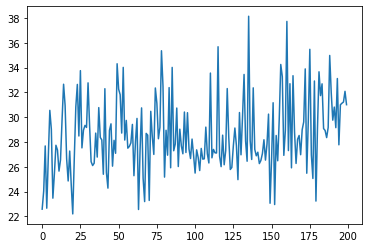

In [85]:
plt.plot(q[:, 2])